In [24]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [23]:
df = pd.read_csv('/Users/dominicprenovost/Programmation/TP2-PF-management/48_Industry_Portfolios.CSV', header=6)
df = df.rename(columns={'Unnamed: 0': 'Date'})

df_48ind = df.iloc[:1171].copy()
df_48ind['Date'] = pd.to_datetime(df_48ind['Date'], format='%Y%m')
df_48ind.set_index('Date', inplace=True)
df_48ind = df_48ind.apply(pd.to_numeric, errors='coerce')
df_48ind.replace(-99.99, np.nan, inplace = True)
df_48ind.replace(-999, np.nan, inplace = True)
df_48ind.dropna(inplace = True)

df_numfirm = df.iloc[2564-20:3735-20].copy()
df_numfirm['Date'] = pd.to_datetime(df_numfirm['Date'], format='%Y%m')
df_numfirm.set_index('Date', inplace=True)
df_numfirm = df_numfirm.apply(pd.to_numeric, errors='coerce')

df_avgsize = df.iloc[3739-22:4910-22].copy()
df_avgsize['Date'] = pd.to_datetime(df_avgsize['Date'], format='%Y%m')
df_avgsize.set_index('Date', inplace=True)
df_avgsize = df_avgsize.apply(pd.to_numeric, errors='coerce')


market_cap = df_numfirm.multiply(df_avgsize, axis=0)
market_cap = market_cap.loc[df_48ind.index]


df_BtoM = df.iloc[4890:4988].copy()
df_BtoM = df_BtoM.apply(pd.to_numeric, errors='coerce')

df_BtoM = df_BtoM.loc[df_BtoM.index.repeat(12)].reset_index(drop=True)

df_BtoM['Date'] = pd.to_datetime(df_BtoM['Date'], format='%Y')

df_BtoM = df_BtoM.drop('Date', axis=1)

df_BtoM.replace(-99.99, np.nan, inplace = True)
df_BtoM.replace(-999, np.nan, inplace = True)
df_BtoM.dropna(inplace = True)

df_BtoM = pd.DataFrame(data = df_BtoM.iloc[5:].values, index = df_48ind.index, columns = df_48ind.columns)


df_mom = df_48ind.rolling(window=12).mean()

df_mom.replace(-99.99, np.nan, inplace = True)
df_mom.replace(-999, np.nan, inplace = True)
df_mom.dropna(inplace = True)


# Créer un objet StandardScaler
scaler = StandardScaler()

def standardize(df):
    # Standardiser les données
    df_scaled = scaler.fit_transform(df)
    
    df_standardized = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    
    return df_standardized

standardized_market_caps = standardize(market_cap)
standardized_BtoM = standardize(df_BtoM)
standardized_mom = standardize(df_mom)

market_weights = market_cap.div(market_cap.sum(axis=1), axis=0)


standardized_market_caps = standardized_market_caps.loc[standardized_mom.index]
standardized_BtoM = standardized_BtoM.loc[standardized_mom.index]
standardized_mom = standardized_mom.loc[standardized_mom.index]
market_weights = market_weights.loc[standardized_mom.index]
df_48ind = df_48ind.loc[standardized_mom.index]

df4 = df_48ind.shift(-1).dropna()

standardized_market_caps = standardized_market_caps.loc[df4.index]
standardized_BtoM = standardized_BtoM.loc[df4.index]
standardized_mom = standardized_mom.loc[df4.index]
market_weights = market_weights.loc[df4.index]
df_48ind = df_48ind.loc[df4.index]

def Expanding_window_optimization(MC, BM, MOM, r, gamma=5):
    
    def u(x, gamma=5):
        return (1+x) ** (1 - gamma) / (1 - gamma)

    def function_to_maximize(beta, MC, BM, MOM, r, T, N, gamma=5):
        wi_t = market_weights
        return -(1/T) * np.sum(u(np.sum((wi_t + (1/N) * (beta[0] * MC + beta[1] * BM + beta[2] * MOM)) * (r),axis=1), gamma))

    optimal_betas = {}  # Define optimal_betas here to store the optimal coefficients for each period
    
    start_year = df_48ind.index.min() # Date de début fixée à la première date dans les données de rendement
    
    # Date de fin initiale fixée à décembre 1973
    initial_end_year = pd.to_datetime('1973-12-01')
    # Date de fin courante, commence par initial_end_year et sera ajustée dans la boucle
    current_end_year = initial_end_year

    while current_end_year <= df_48ind.index.max(): # Boucle jusqu'à la dernière date dans les données de rendement 
        
        # Extraire les composantes nécessaires pour l'optimisation des coefficients pour la période sélectionnée dans la window
        MC = standardized_market_caps.loc[start_year:current_end_year]
        BM = standardized_BtoM.loc[start_year:current_end_year]
        MOM = standardized_mom.loc[start_year:current_end_year]
        r = df_48ind.loc[start_year:current_end_year]
            
        N = df_48ind.shape[1]
        T = df_48ind.shape[0]

        # Initial guess for theta
        initial_beta = np.array([0.5, 0.5, 0.5])

        # Run the optimization for the current period
        result = minimize(function_to_maximize, initial_beta, args=( MC, BM, MOM, r, T, N, gamma), method='SLSQP')

        # Store the optimal theta for the current period
        optimal_betas[current_end_year] = result.x if result.success else None
        
        optimal_weights = {}

        for end_year, betas in optimal_betas.items():
            # Calculer les poids optimaux pour chaque période
            weights = market_weights + (1 / len(market_weights.columns)) * (betas[0] * standardized_market_caps + betas[1] * standardized_BtoM + betas[2] * standardized_mom)
            optimal_weights[end_year] = weights

        #optimal_weights = market_weights + (1 / len(market_weights.columns)) * (optimal_betas[0] * standardized_market_caps + optimal_betas[1] * standardized_BtoM + optimal_betas[2] * standardized_mom)

        # Élargir la fenêtre pour la prochaine itération de window en ajoutant 12 mois à la dernière date courante de fin 
        current_end_year += pd.DateOffset(months=12)

    return optimal_betas, optimal_weights


optimal_betas, optimal_weights = Expanding_window_optimization(standardized_market_caps, standardized_BtoM, standardized_mom, df_48ind)


In [13]:
optimal_betas

{Timestamp('1973-12-01 00:00:00'): array([0.34905249, 0.84081479, 0.81488704]),
 Timestamp('1974-12-01 00:00:00'): array([0.51253805, 0.42460914, 0.43492456]),
 Timestamp('1975-12-01 00:00:00'): array([0.51244915, 0.42471563, 0.43505097]),
 Timestamp('1976-12-01 00:00:00'): array([0.50677275, 0.45469722, 0.46011117]),
 Timestamp('1977-12-01 00:00:00'): array([0.47268914, 0.43267301, 0.46262585]),
 Timestamp('1978-12-01 00:00:00'): array([0.46933959, 3.37033861, 0.34243519]),
 Timestamp('1979-12-01 00:00:00'): array([0.46923087, 3.37021339, 0.34228188]),
 Timestamp('1980-12-01 00:00:00'): array([0.46949496, 3.37078285, 0.34208125]),
 Timestamp('1981-12-01 00:00:00'): array([ 5.81110851, -6.49236062, -2.63882682]),
 Timestamp('1982-12-01 00:00:00'): array([ 6.04819586, -6.60483293, -2.61183678]),
 Timestamp('1983-12-01 00:00:00'): array([ 5.84298018, -6.38857569, -2.59683628]),
 Timestamp('1984-12-01 00:00:00'): array([ 5.84228077, -6.39077225, -2.59057565]),
 Timestamp('1985-12-01 00:00

In [18]:
optimal_weights

{Timestamp('1973-12-01 00:00:00'):                Agric     Food      Soda      Beer      Smoke     Toys   \
 Date                                                                     
 1970-06-01  0.016246  0.009168 -0.011815 -0.002691  0.015929 -0.023272   
 1970-07-01  0.022728  0.024342 -0.004307  0.005872  0.023179 -0.010296   
 1970-08-01  0.018868  0.019376 -0.010154 -0.003098  0.020234 -0.006756   
 1970-09-01  0.029631  0.024113 -0.011899  0.001623  0.016986 -0.003668   
 1970-10-01  0.012488  0.015611 -0.014005 -0.010533  0.015037 -0.010042   
 ...              ...       ...       ...       ...       ...       ...   
 2023-08-01 -0.002158  0.010691  0.002879  0.003222  0.001701 -0.000335   
 2023-09-01  0.003127  0.012561  0.003972  0.001909  0.007563  0.004674   
 2023-10-01 -0.013119 -0.005918 -0.003932 -0.012470 -0.005822 -0.007769   
 2023-11-01 -0.017903 -0.006275 -0.006144 -0.012853 -0.007153 -0.009615   
 2023-12-01 -0.002434  0.001272 -0.003387 -0.008137 -0.007413  0.0

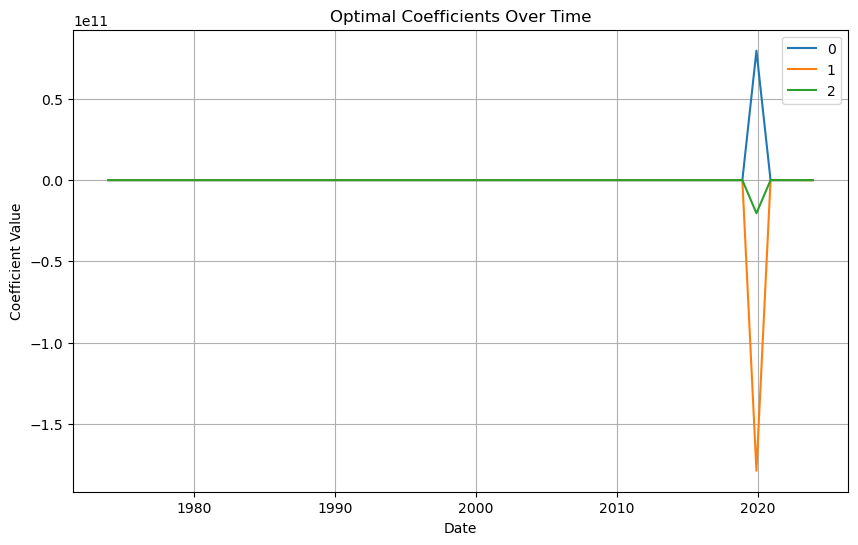

In [14]:
import matplotlib.pyplot as plt

# Convertir les résultats optimaux en DataFrame pour faciliter la manipulation
optimal_betas_df = pd.DataFrame(optimal_betas).T

# Tracer les coefficients optimaux
plt.figure(figsize=(10, 6))
for column in optimal_betas_df.columns:
    plt.plot(optimal_betas_df.index, optimal_betas_df[column], label=column)

plt.title('Optimal Coefficients Over Time')
plt.xlabel('Date')
plt.ylabel('Coefficient Value')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
from sklearn.linear_model import LinearRegression

def calculate_regression_coefficients(N, returns, characteristic1, characteristic2, characteristic3):

    model = LinearRegression()

    theta_initial = []

    for i in range(N):
        y = returns.iloc[:, i]
        X1 = characteristic1.iloc[:, i]
        X2 = characteristic2.iloc[:, i]
        X3 = characteristic3.iloc[:, i]

        X_combined = pd.concat([X1, X2, X3], axis=1)

        model.fit(X_combined, y)
        theta_initial.append(model.coef_)

    return theta_initial


calculate_regression_coefficients(df_48ind.shape[1], df_48ind, standardized_market_caps, standardized_BtoM, standardized_mom)

[array([-0.21990969,  0.29295582,  1.67938142]),
 array([-0.19354384,  0.07230163,  1.33218765]),
 array([-0.04408101,  0.17607979,  1.8698786 ]),
 array([-0.29344122, -0.08232346,  1.52621908]),
 array([-0.56340042, -0.29529744,  1.69428083]),
 array([-0.72363955,  0.12599766,  2.11757739]),
 array([-0.56319754,  0.06705037,  2.18200799]),
 array([-0.23525004,  0.29484261,  1.8677892 ]),
 array([-0.20189189,  0.09627003,  1.26928718]),
 array([-0.05964451,  0.44759323,  1.93902847]),
 array([-0.29081665,  0.435161  ,  2.20535779]),
 array([-0.05114307,  0.31905131,  1.56068009]),
 array([-0.10768417,  0.16715909,  1.5223704 ]),
 array([-0.37616414,  0.06232569,  1.52550745]),
 array([-0.30240796,  0.06323133,  1.56792877]),
 array([-0.77986923, -0.01767575,  2.168224  ]),
 array([-0.30717532,  0.22772086,  1.81509201]),
 array([-0.02595109,  0.73524423,  2.14385437]),
 array([-1.98923578, -0.9594226 ,  2.785929  ]),
 array([-0.95066043,  0.14976975,  2.34830699]),
 array([-0.23723742,